## **基于CNN的儿童胸部X光图像肺炎检测算法**

### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">导入库</p>

##### [Kaggle_BaseOn_Xception_94%]('https://www.kaggle.com/code/abdmental01/chest-x-ray-xception-94')

In [1]:
# 导入相关库
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用微软雅黑
plt.rcParams['axes.unicode_minus'] = False  # 支持负号
# 读取图像
import matplotlib.image as mpimg
# TensorFlow 和 Keras 层、模型、优化和损失
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import * 
from tensorflow.keras.losses import BinaryCrossentropy # 二元交叉熵损失函数
# 初始化内核。LabelEncoder 工具将将文本标签转换为数值标签
from sklearn.preprocessing import LabelEncoder 
# 自适应矩估计优化器
from tensorflow.keras.optimizers import Adam , Adamax
# 预训练模型 Xception
from tensorflow.keras.applications import *
# 早停回调函数。在训练过程中监控验证集的性能，当性能不再提升时提前停止训练
from tensorflow.keras.callbacks import EarlyStopping
import warnings 
warnings.filterwarnings("ignore")

### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">调用GPU</p>

In [2]:
USE_GPU = True 
if USE_GPU:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU 启用成功:", gpus)
    else:
        print("❌ 未检测到 GPU，将使用 CPU。")
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    print("🚫 GPU 计算关闭，使用 CPU。")

✅ GPU 启用成功: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">载入数据</p>

In [3]:
# 训练集文件目录
train_directory = "../data/train"

filepath =[] # 存储图像存放路径
label = [] # 存储对应标签

folds = os.listdir(train_directory)

for fold in folds:
    f_path = os.path.join(train_directory, fold)
    imgs = os.listdir(f_path)

    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)

# 链接数据路径和标签
file_path_series = pd.Series(filepath, name='filepath')
Label_path_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, Label_path_series], axis=1) 
# 查看随机数据情况
df_train.sample(5) 

,filepath,label
5177,../data/train\PNEUMONIA\person980_virus_1655.jpeg,PNEUMONIA
274,../data/train\NORMAL\IM-0475-0001.jpeg,NORMAL
4816,../data/train\PNEUMONIA\person765_bacteria_266...,PNEUMONIA
1911,../data/train\PNEUMONIA\person1295_virus_2223....,PNEUMONIA
1341,../data/train\PNEUMONIA\person1000_bacteria_29...,PNEUMONIA


In [4]:
# 测试集文件目录
test_directory = "../data/test"

filepath =[] # 存储图像存放路径
label = [] # 存储对应标签

folds = os.listdir(train_directory)

for fold in folds:
    f_path = os.path.join(test_directory, fold)
    imgs = os.listdir(f_path)

    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)

# 链接数据路径和标签
file_path_series = pd.Series(filepath, name='filepath')
Label_path_series = pd.Series(label, name='label')
df_test = pd.concat([file_path_series, Label_path_series], axis=1) 
# 查看随机数据情况
df_test.sample(5) 

,filepath,label
249,../data/test\PNEUMONIA\person104_bacteria_491....,PNEUMONIA
123,../data/test\NORMAL\NORMAL2-IM-0201-0001.jpeg,NORMAL
20,../data/test\NORMAL\IM-0028-0001.jpeg,NORMAL
362,../data/test\PNEUMONIA\person141_bacteria_681....,PNEUMONIA
52,../data/test\NORMAL\IM-0085-0001.jpeg,NORMAL


In [5]:
# 数据大小
print(f'Train Data 大小：{df_train.shape}') 
print(f'Test Data 大小：{df_test.shape}')

Train Data 大小：(5216, 2)
Test Data 大小：(624, 2)


### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">制作训练、测试和验证数据集</p>

In [6]:
# 图像大小
IMAGE_SIZE = (256, 256)

print('训练图像集：')
# 创建训练数据集
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_directory, # 文件路径已定义
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('验证图像集：')
# 创建验证数据集
validation_ds = tf.keras.utils.image_dataset_from_directory(
    train_directory, # 文件路径已定义
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('测试图像集：')
# 创建测试数据集
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_directory, # 文件路径已定义
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

训练图像集：
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
验证图像集：
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
测试图像集：
Found 624 files belonging to 2 classes.


### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">提取类别标签</p>

In [7]:
# 提取 labels
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

# 定义类别标签
class_labels = ['NORMAL', 'PNEUMONIA'] 

# 初始化标签，将文本标签转换为数值标签
label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

# 转化标签
train_labels_encoded = label_encoder.transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [8]:
# 查看数据集形状
for image_batch, labels_batch in train_ds:
    print("Shape of X_train: ", image_batch.shape)
    print("Shape of y_train: ", labels_batch.shape)
    break

Shape of X_train:  (32, 256, 256, 3)
Shape of y_train:  (32,)


### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">像素值归一化</p>

In [9]:
# 训练集数据
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
# 验证集数据 
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
# 测试集数据
test_ds = test_ds.map(lambda x, y: (x / 255.0, y)) 

### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">训练集标签视觉计数</p>

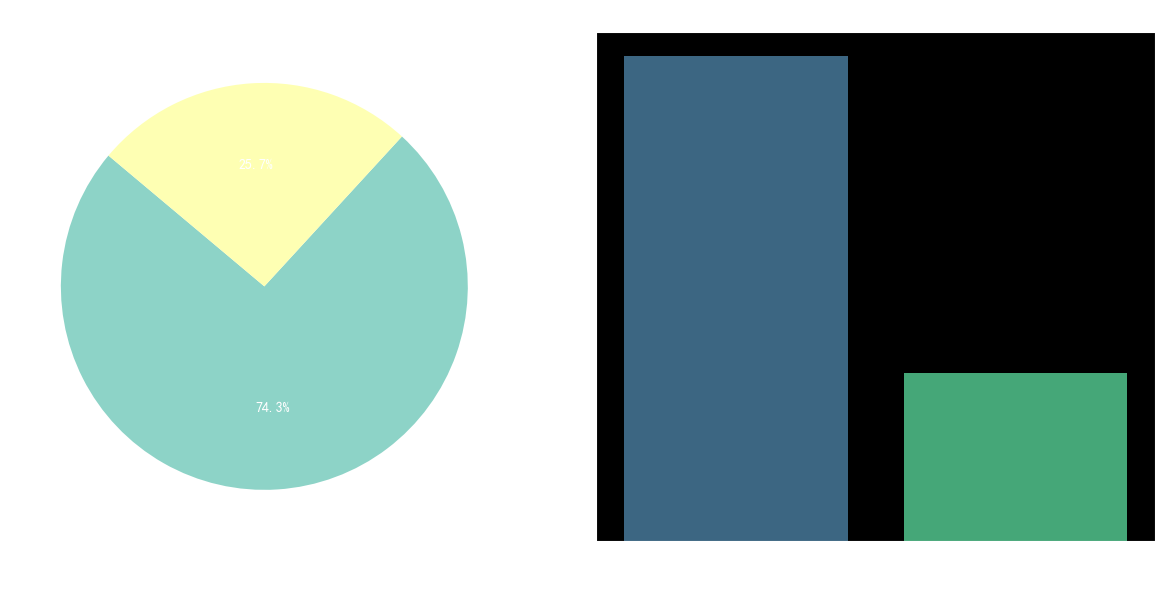

In [10]:
# 计算每个类别的出现次数
count = df_train['label'].value_counts()

# 创建一图二子图
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# 第一个子图绘制饼图
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('类别分布图')

# 第二个子图绘制柱状图
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('类别统计数图')

# 调整图像结构
plt.tight_layout()

# 保存并展示图像
# plt.savefig('out_fig/train_visual_label_count'+'.png', dpi=300)
plt.show()

### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">测试集标签视觉计数</p>

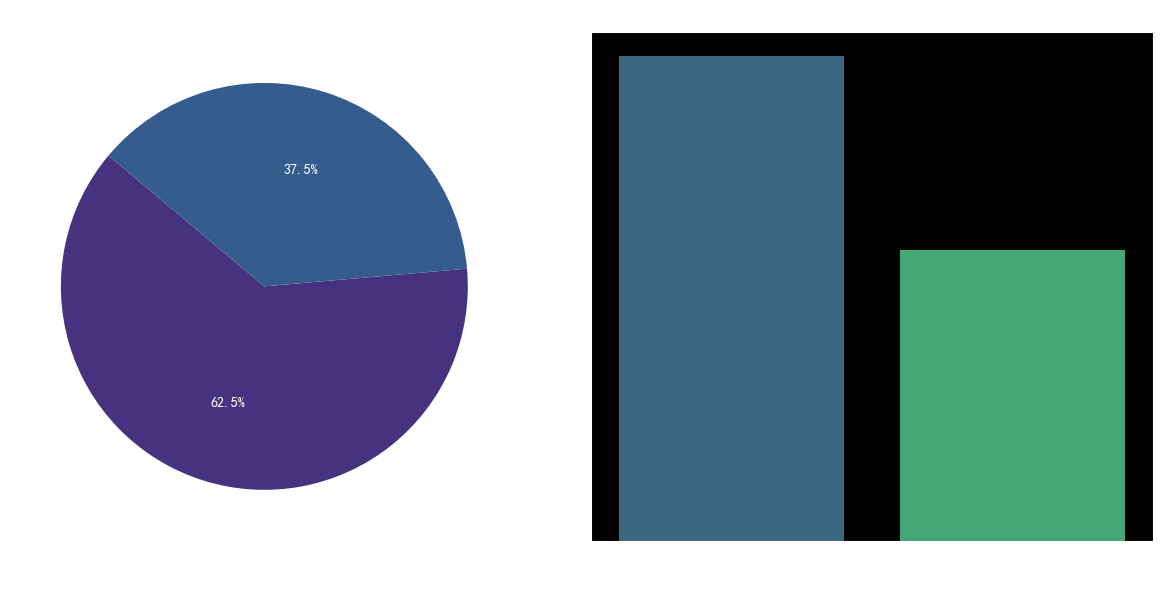

In [11]:
# 计算每个类别的出现次数
count = df_test['label'].value_counts()

# 创建一图二子图
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# 第一个子图绘制饼图
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('类别分布图')

# 第二个子图绘制柱状图
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('类别统计数图')

# 调整图像结构
plt.tight_layout()

# 保存并展示图像
# plt.savefig('out_fig/test_visual_label_count'+'.png', dpi=300)
plt.show()

### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">可视化训练集图像</p>

In [12]:
def visualize_images(path, num_images=5):
    # 获取指定路径下图像文件名的列表
    image_filenames = os.listdir(path)
    
    # 如果图像数量超过num_images，则限制可视化的图像数量
    num_images = min(num_images, len(image_filenames))
    
    # 创建画布
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')
    
    # 遍历展示图像
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # 使用 Matplotlib 载入图像
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        
        # 展示图像
        axes[i].imshow(image)
        axes[i].axis('off')  # 关闭坐标轴显示
        axes[i].set_title(image_filename)  # 以图片文件名作为标题
    
    # 调整图像布局并展示
    plt.tight_layout()
    plt.show()

### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">正常肺部影像</p>

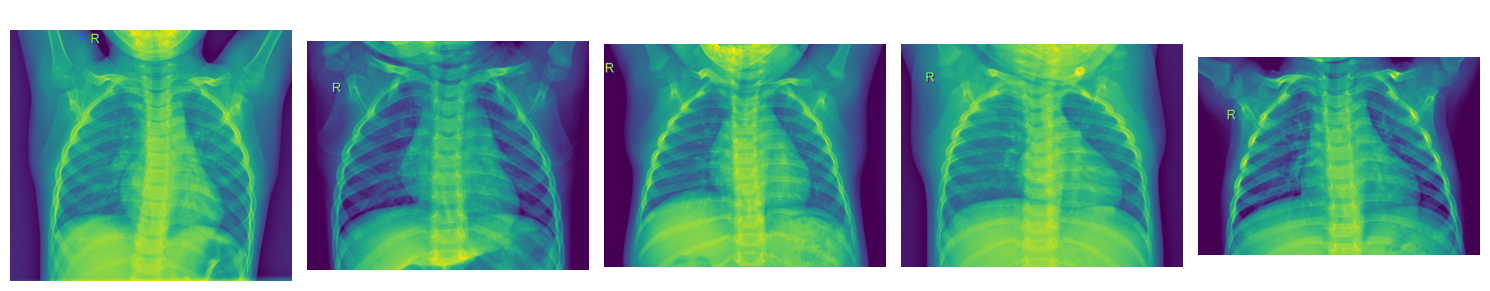

In [13]:
# 可视化图像路径
path_to_visualize = f"{train_directory}/NORMAL"

# 部分图像可视化
visualize_images(path_to_visualize, num_images=5)

### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">患肺炎肺部影像</p>

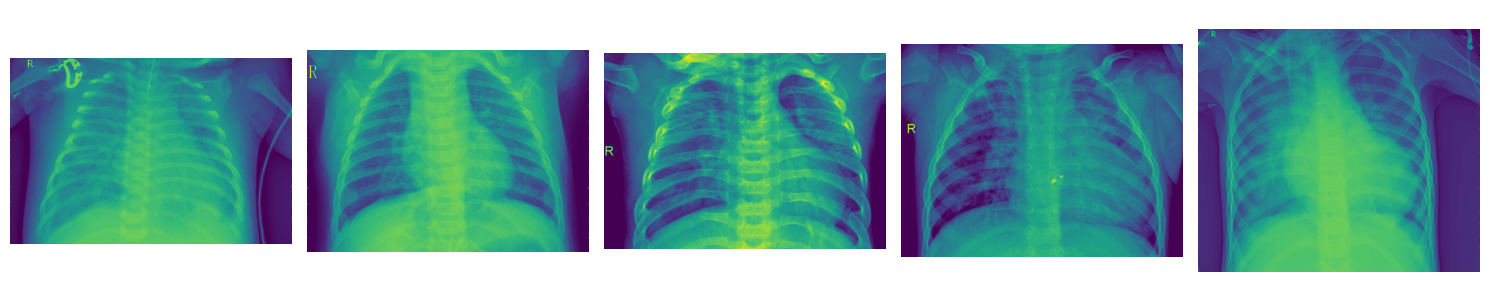

In [14]:
# 可视化图像路径
path_to_visualize = f"{train_directory}/PNEUMONIA"

# 部分图像可视化
visualize_images(path_to_visualize, num_images=5)

## <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">构建模型</p>

#### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">迁移学习（Transfer Learn）</p>

**迁移学习是一种机器学习技术，其中从训练一个模型中获得的知识被应用于不同但相关的任务。不是从头开始，而是使用预训练模型作为起点。通过利用预训练模型训练期间学习的特征，新模型可以在更少的数据和计算下实现更好的性能。这种方法在处理有限标记数据或计算资源时特别有用。迁移学习涉及通过调整其参数来微调预训练模型，以更好地适应新任务。这个过程允许更快地收敛并提高对新任务的一般化。总的来说，迁移学习通过利用先前任务中学到的知识，加速了各种任务模型的开发。**

1. 加载预训练的 Xception 模型
```python
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))
```
- `Xception`：加载 Xception 模型架构。Xception 是一种深度卷积神经网络，预训练于 ImageNet 数据集。
- `weights='imagenet'`：指定模型使用 ImageNet 数据集上预训练的权重。
- `include_top=False`：排除模型的顶部（分类）层，允许我们添加自己的自定义分类层。
- `pooling='avg'`：使用全局平均池化将基础模型的 3D 输出张量转换为 1D 张量。
- `input_shape=(256, 256, 3)`：指定模型期望的输入图像形状为 256x256 像素，3 个通道（RGB）。

2. 冻结基础模型的层
```python
base_model.trainable = False
```
- `base_model.trainable = False`：冻结基础模型中的所有层，防止它们在训练过程中更新。这有助于利用预训练模型的特征提取能力，同时减少训练时间和计算资源。

3. 初始化顺序模型
```python
model = Sequential()
```
- `Sequential`：初始化一个顺序模型，其中层按顺序添加。

4. 添加基础模型
```python
model.add(base_model)
```
- `model.add(base_model)`：将预训练的 Xception 基础模型添加到顺序模型中。

5. 添加批量归一化层
```python
model.add(BatchNormalization())
```
- `BatchNormalization`：添加一个批量归一化层，用于归一化前一层的激活值，有助于加速训练过程并提高模型的稳定性。

6. 添加 Dropout 层
```python
model.add(Dropout(0.45))
```
- `Dropout(0.45)`：添加一个 Dropout 层，Dropout 率为 0.45。在训练过程中随机丢弃 45% 的输入单元，有助于防止过拟合。

7. 添加全连接层
```python
model.add(Dense(220, activation='relu'))
```
- `Dense(220, activation='relu')`：添加一个全连接层，包含 220 个单元，使用 ReLU 激活函数。

8. 添加 Dropout 层
```python
model.add(Dropout(0.25))
```
- `Dropout(0.25)`：添加另一个 Dropout 层，Dropout 率为 0.25。在训练过程中随机丢弃 25% 的输入单元，进一步防止过拟合。

9. 添加全连接层
```python
model.add(Dense(60, activation='relu'))
```
- `Dense(60, activation='relu')`：添加另一个全连接层，包含 60 个单元，使用 ReLU 激活函数。

10. 添加输出层
```python
model.add(Dense(1, activation='sigmoid'))
```
- `Dense(1, activation='sigmoid')`：添加输出层，包含 1 个单元，使用 Sigmoid 激活函数，适用于二分类任务。

11. 编译模型
```python
model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
```
- `optimizer=Adamax(learning_rate=0.001)`：使用 Adamax 优化器，学习率为 0.001。
- `loss='binary_crossentropy'`：使用二元交叉熵损失函数，适用于二分类任务。
- `metrics=['accuracy']`：使用准确率作为评估指标。

12. 打印模型摘要
```python
model.summary()
```
- `model.summary()`：打印模型架构的摘要，包括每层的参数数量。

In [15]:
# 加载 Xception 基础模型，不带顶部层
base_model = Xception(weights='../models/pretrained/xception_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      include_top=False, 
                      pooling='avg', 
                      input_shape=(256, 256, 3))

base_model.trainable = False

model = Sequential()

model.add(base_model)

model.add(BatchNormalization())

model.add(Dropout(0.45)) 

model.add(Dense(220, activation='relu'))

model.add(Dropout(0.25)) 

model.add(Dense(60,activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 220)               450780    
                                                                 
 dropout_1 (Dropout)         (None, 220)               0         
                                                                 
 dense_1 (Dense)             (None, 60)                13260     
                                                        

#### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">编译与拟合</p>

In [16]:
# 早停回调
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, # 验证集的损失在连续 5 个 epoch 中没有改善，则停止训练
                               restore_best_weights=True)

# 拟合模型
history = model.fit(train_ds,
                    epochs= 20,
                    validation_data = validation_ds,
                    callbacks = early_stopping)

Epoch 1/20
147/147 [==============================] - 24s 131ms/step - loss: 0.1988 - accuracy: 0.9182 - val_loss: 0.1673 - val_accuracy: 0.9482
Epoch 2/20
147/147 [==============================] - 17s 115ms/step - loss: 0.1365 - accuracy: 0.9463 - val_loss: 0.0993 - val_accuracy: 0.9693
Epoch 3/20
147/147 [==============================] - 17s 114ms/step - loss: 0.1214 - accuracy: 0.9570 - val_loss: 0.0785 - val_accuracy: 0.9712
Epoch 4/20
147/147 [==============================] - 17s 116ms/step - loss: 0.1055 - accuracy: 0.9617 - val_loss: 0.0800 - val_accuracy: 0.9731
Epoch 5/20
147/147 [==============================] - 16s 106ms/step - loss: 0.0973 - accuracy: 0.9623 - val_loss: 0.0689 - val_accuracy: 0.9770
Epoch 6/20
147/147 [==============================] - 16s 109ms/step - loss: 0.0844 - accuracy: 0.9672 - val_loss: 0.0658 - val_accuracy: 0.9789
Epoch 7/20
147/147 [==============================] - 16s 109ms/step - loss: 0.0784 - accuracy: 0.9706 - val_loss: 0.0662 - val_ac

#### <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">验证损失与准确率</p>

In [17]:
# 在验证集上评估模型
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# 输出验证集损失与准确率
print("验证损失：", validation_loss)
print("验证准确率：", validation_accuracy)

17/17 [==============================] - 2s 89ms/step - loss: 0.0688 - accuracy: 0.9770
验证损失： 0.06880687922239304
验证准确率： 0.9769673943519592


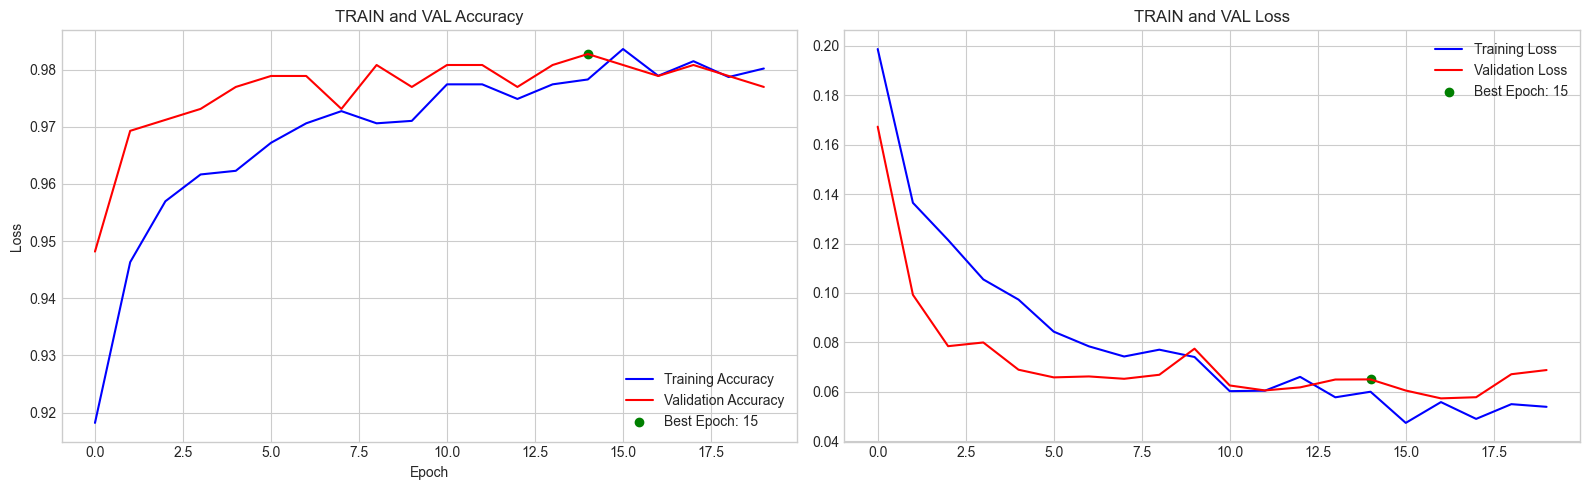

In [18]:
# 获取验证集最高准确率的 epoch
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# 绘制图像
plt.style.use('seaborn-v0_8-whitegrid')
# 创建 1 行 2 列子图
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# 绘制训练和验证准确率图像
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('TRAIN and VAL Accuracy')
axs[0].legend()

# 绘制训练和验证损失值图像
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[1].set_title('TRAIN and VAL Loss')
axs[1].legend()

plt.tight_layout()
# plt.savefig("out_fig/best_epoch.png", dpi=300)
plt.show()

## <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#87CEEB;">模型预测</p>

In [ ]:
# 保存模型
# model.save('../models/final/CNN_ChildPneumonia_based_on_Xception.keras')

In [27]:
# 加载模型
from tensorflow.keras.models import load_model

# 加载模型
model = load_model('../models/final/CNN_ChildPneumonia_based_on_Xception.keras')

Testing Images:
Found 624 files belonging to 2 classes.
测试集图像：
20/20 [==============================] - 2s 103ms/step


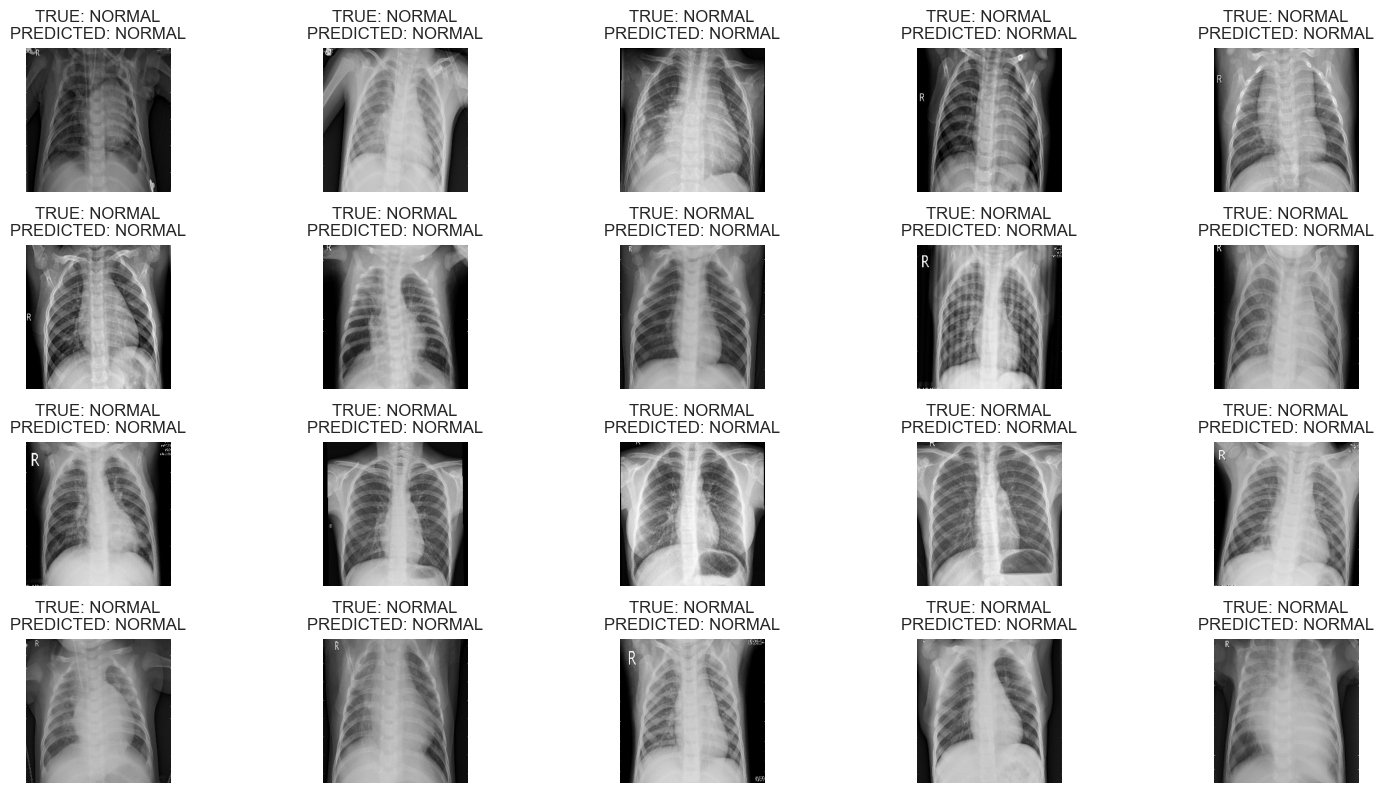

In [29]:
test_dir = '../data/test/'
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# 绘制图像及其真实和预测标签
def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    # 为一组图像生成预测结果
    predictions = model.predict(dataset)
    # 打乱数据集
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        # 将张量转换为 NumPy 数组
        images = images.numpy()
        
        # 遍历批次中的每张图像
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:  # 检查图像总数是否超过所需数量
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))  
                plt.title(f'TRUE: {true_class}\nPREDICTED: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# 在测试数据集中随机选择 20 张图像并可视化预测结果
print('测试集图像：')
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)

1/1 [==============================] - 0s 17ms/step


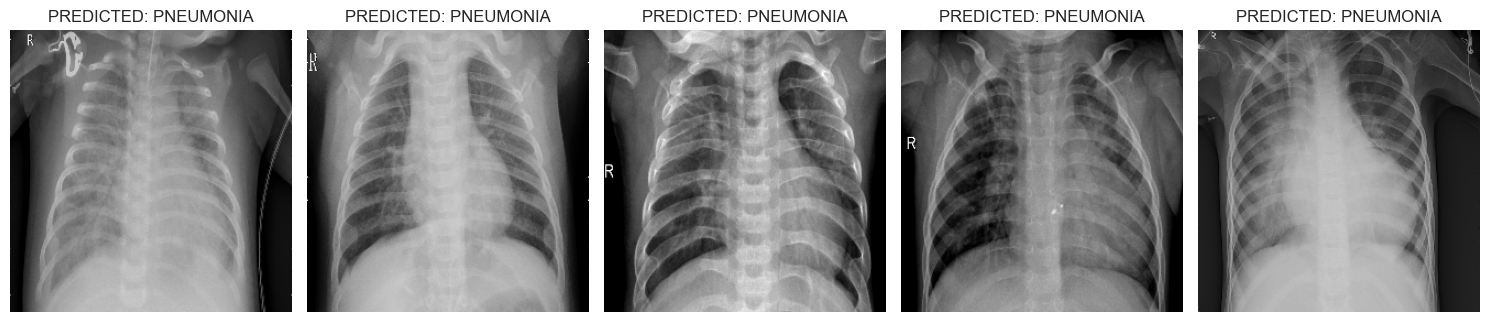

In [30]:
# 测试集患病图像路径
test_directory_path = f"{train_directory}/PNEUMONIA"

# 从目录中选择前 5 个图像文件
image_files = os.listdir(test_directory_path)[:5]

# 创建一个图形和子图
fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

# 加载和预处理每个图像，进行预测，并使用循环显示它们
for i, image_file in enumerate(image_files):
    img_path = os.path.join(test_directory_path, image_file)
    # 使用 OpenCV 加载图像
    img = cv2.imread(img_path)
    # 将图像调整为 (256, 256)
    img = cv2.resize(img, (256, 256)) 

    # 归一化像素值
    img_array = img.astype(np.float32) / 255.0  

    # 扩展维度以匹配模型期望的输入形状
    img_array = np.expand_dims(img_array, axis=0)

    # 进行预测
    predictions = model.predict(img_array)
    actual_prediction = (predictions > 0.5).astype(int)

    # 显示图像及其预测标签
    # 将 BGR 转换为 RGB 以便使用 matplotlib 显示
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    axs[i].axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'NORMAL'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'PREDICTED: {predicted_label}')

# 调整布局
plt.tight_layout()
# 保存并展示图像
# plt.savefig('out_fig/result_actual_prediction'+'.png', dpi=300)
plt.show()